# Model training with Early Stopping
Pytorch tutorial: [optimization_tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Prerequisite Code

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
import pandas as pd
from torchsummary import summary

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cpu device
num_workers = 8 cores


In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:19<00:00, 1.37MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 147kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.8MB/s]


In [6]:
import numpy as np
from torch.utils.data import Dataset, SubsetRandomSampler
valid_size=0.2
train_length=len(training_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]

train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

In [7]:
# prompt: get num_workers from CPU cores

import os

num_workers = os.cpu_count()
print(f"Number of workers: {num_workers}")

Number of workers: 8


In [8]:
batch_size=32
train_loader=torch.utils.data.DataLoader(training_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
val_loader=torch.utils.data.DataLoader(training_data,batch_size=batch_size,sampler=valid_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [9]:
im,label=training_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([1, 28, 28])
9


In [10]:
len(train_loader)

1500

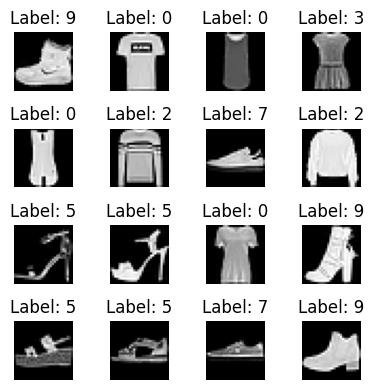

In [11]:
# prompt: show 16 image from training_data using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = training_data.__getitem__(i)
    axes[row, col].imshow(im.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [12]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [13]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [14]:
def train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weight=None
    for ep in range(epochs):
        print(f"Epoch {ep+1}\n-------------------------------")
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        val_loss = test_loss(val_loader, model, loss_fn)
        print(f"Epoch {ep+1} Train loss: {train_loss:>7f}  Val loss: {val_loss:>7f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_weight=model.state_dict().copy()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    print("Done!")
    model.load_state_dict(best_weight)
    return model

def test_loss(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= batch
    return train_loss

In [15]:
learning_rate = 1e-3
batch_size = 64
epochs = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=epochs)

Epoch 1
-------------------------------
Epoch 1 Train loss: 2.304499  Val loss: 2.303174
Epoch 2
-------------------------------


KeyboardInterrupt: 

In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    true_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted_labels, true_labels

# Workshop II 01 early stopping
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ โดยการหยุกฝึกด้วย early stopping ฟร้อมวัดประสิทธิภาพ

In [ ]:
!unzip /content/Small_Data_CoV2.zip

Archive:  /content/Small_Data_CoV2.zip
   creating: Small_Data_CoV2_val/
   creating: Small_Data_CoV2_val/Covid/
   creating: Small_Data_CoV2_val/Covid/Patient (10)/
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132320.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132449.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132516.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132540.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132608.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132636.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132704.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132740.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132814.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-

In [ ]:
#Create empty lists
df_dic = {}
filename = []
label = []
#read all file from subfolders
for foldername in ['Small_Data_CoV2_train', 'Small_Data_CoV2_test', 'Small_Data_CoV2_val']:
    for dirname, _, filenames in os.walk(os.path.join('/content', foldername)):
        for file in filenames:
            f = os.path.join(dirname, file)
            if '.png' in f:
                filename.append(f)
                label.append(dirname.split('/')[-2])
    #Create a dataframe
    df_dic[foldername.split('_')[-1]] = pd.DataFrame({'filename':filename, 'label':label})
df_dic['train']

,filename,label
0,/content/Small_Data_CoV2_train/Others/Patient ...,Others
1,/content/Small_Data_CoV2_train/Others/Patient ...,Others
2,/content/Small_Data_CoV2_train/Others/Patient ...,Others
3,/content/Small_Data_CoV2_train/Others/Patient ...,Others
4,/content/Small_Data_CoV2_train/Others/Patient ...,Others
...,...,...
592,/content/Small_Data_CoV2_train/Covid/Patient (...,Covid
593,/content/Small_Data_CoV2_train/Covid/Patient (...,Covid
594,/content/Small_Data_CoV2_train/Covid/Patient (...,Covid
595,/content/Small_Data_CoV2_train/Covid/Patient (...,Covid


In [157]:
conv = nn.Sequential(
      nn.Conv2d(3, 32,kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(32, 512, kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(512, 1024, kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(1024, 2048, kernel_size=3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(2048, 512, kernel_size=3,padding=1),
      nn.ReLU(),
)

conv.to(device)
summary(conv, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4        [-1, 512, 112, 112]         147,968
              ReLU-5        [-1, 512, 112, 112]               0
         MaxPool2d-6          [-1, 512, 56, 56]               0
            Conv2d-7         [-1, 1024, 56, 56]       4,719,616
              ReLU-8         [-1, 1024, 56, 56]               0
         MaxPool2d-9         [-1, 1024, 28, 28]               0
           Conv2d-10         [-1, 2048, 28, 28]      18,876,416
             ReLU-11         [-1, 2048, 28, 28]               0
        MaxPool2d-12         [-1, 2048, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       9,437,696
             ReLU-14          [-1, 512,

In [158]:
class CNNNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
    nn.Conv2d(3, 32,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 512, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(512, 1024, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(1024, 2048, kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(2048, 512, kernel_size=3,padding=1),
    nn.ReLU(),
    )
    self.flatten = nn.Flatten()
    self.fc = nn.Sequential(
      nn.Linear(512*14*14, 512),
      nn.ReLU(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Linear(128, 3),
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.flatten(x)
    out = self.fc(x)
    return out

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
le = LabelEncoder()
df_dic['train']['label'] = le.fit_transform(df_dic['train']['label'])
df_dic['test']['label'] = le.fit_transform(df_dic['test']['label'])
df_dic['val']['label'] = le.fit_transform(df_dic['val']['label'])

In [ ]:
display(df_dic['train'][df_dic['train']['label'] ==0].head(1), df_dic['train'][df_dic['train']['label'] == 1].head(1), df_dic['train'][df_dic['train']['label'] == 2].head(1))

,filename,label
291,/content/Small_Data_CoV2_train/Covid/Patient (...,0


,filename,label
162,/content/Small_Data_CoV2_train/Healthy/Patient...,1


,filename,label
0,/content/Small_Data_CoV2_train/Others/Patient ...,2


In [ ]:
display(df_dic['test'][df_dic['test']['label'] ==0].head(1), df_dic['test'][df_dic['test']['label'] == 1].head(1), df_dic['test'][df_dic['test']['label'] == 2].head(1))

,filename,label
291,/content/Small_Data_CoV2_train/Covid/Patient (...,0


,filename,label
162,/content/Small_Data_CoV2_train/Healthy/Patient...,1


,filename,label
0,/content/Small_Data_CoV2_train/Others/Patient ...,2


In [ ]:
X_train = df_dic['train']['filename']
y_train = df_dic['train']['label']

X_test = df_dic['test']['filename']
y_test = df_dic['test']['label']

X_val = df_dic['val']['filename']
y_val = df_dic['val']['label']
# X_train

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, im_filename, y, transform=None):
    self.im_filename = im_filename
    self.y = y
    self.transform = transform

  def __len__(self):
    return self.im_filename.shape[0]

  def __getitem__(self, idx):
    img_path = self.im_filename.iloc[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.y.iloc[idx]
    label = torch.tensor(int(label), dtype=torch.long)

    if self.transform:
        image = self.transform(image)
    image = np.array(image)
    return image, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [ ]:
train_dataset = CustomImageDataset(X_train, y_train, transform)
val_dataset = CustomImageDataset(X_val, y_val, test_transform)
test_dataset = CustomImageDataset(X_test, y_test, test_transform)
im, label = train_dataset.__getitem__(0)
print(label, im.shape)

tensor(2) (3, 224, 224)


In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=32,num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [159]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): L

In [160]:
learning_rate = 0.001
batch_size = 32
epochs = 200

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs=epochs)

Epoch 1
-------------------------------
Epoch 1 Train loss: 1.161584  Val loss: 1.097098
Epoch 2
-------------------------------
Epoch 2 Train loss: 1.157384  Val loss: 1.094171
Epoch 3
-------------------------------
Epoch 3 Train loss: 1.153490  Val loss: 1.091235
Epoch 4
-------------------------------
Epoch 4 Train loss: 1.149731  Val loss: 1.088419
Epoch 5
-------------------------------
Epoch 5 Train loss: 1.145981  Val loss: 1.085707
Epoch 6
-------------------------------
Epoch 6 Train loss: 1.142575  Val loss: 1.083129
Epoch 7
-------------------------------
Epoch 7 Train loss: 1.139241  Val loss: 1.080528
Epoch 8
-------------------------------
Epoch 8 Train loss: 1.135648  Val loss: 1.077856
Epoch 9
-------------------------------
Epoch 9 Train loss: 1.132072  Val loss: 1.075216
Epoch 10
-------------------------------
Epoch 10 Train loss: 1.128509  Val loss: 1.072667
Epoch 11
-------------------------------
Epoch 11 Train loss: 1.125083  Val loss: 1.070082
Epoch 12
--------

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=100352, out_features=512, bias=True)
    (1): ReLU()
    (2): L

In [162]:
result = test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 48.2%, Avg loss: 1.036631 

